# Formula 1 Grand Prix Prediction

## Introdução

- Motivo para fazer esse projeto
- O que é Formula 1

## 1. Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

SEED = 42

## 2. Leitura dos dados

Os dados utilizados para esses experimentos foram providos pela [Ergast Developer API](https://ergast.com/mrd/) e encontrados pelo Kaggle em [Formula 1 World Championship - 1950 to 2020](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020).

Os arquivos CSV possuem as seguintes informações:
- **results.csv**: Resultados de cada piloto em cada uma das corridas como posição final, tempo de corrida, pontos acumulados.
- **races.csv**: Informações de todos os Grand Prix ja realizados como: nome, data e horário de início.
- **qualifying.csv**: Resultados da classificação realizadas para cada corrida, como: Tempo de volta no Q1, Q2 e Q3, posição final na classificação.
- **drivers.csv**: Armazena as informações de todos os pilotos que ja competiram na F1, como nome, data de nascimento, nacionalidade.
- **constructors.csv**: Armazena as informações de todas as equipes que ja participaram da F1, como nome, nacionalidade.
- **circuits.csv**: Armazena todos dados dos circuitos ja adicionados no calendario da F1, como nome, localização geografica, nacionalidade.

Todas as informações disponíveis não vão ser explicadas de início. Posteriormente as informações relevantes serão resumidas em um Dataframe e então as colunas serão explicadas antes de serem aplicadas.

In [2]:
results = pd.read_csv('data/results.csv')
races = pd.read_csv('data/races.csv')
quali = pd.read_csv('data/qualifying.csv')
drivers = pd.read_csv('data/drivers.csv')
constructors = pd.read_csv('data/constructors.csv')
circuit = pd.read_csv('data/circuits.csv')

## 3. Pré-processamento

O preprocessamento das informações irá envolver a criação de um novo dataset somente com as colunas necessárias de todos os arquivos CSVs apresentados.

Para isso todos os datasets serão unidos em uma única estrutura de dados e novas colunas serão adicionadas, enquanto outras serão modificadas ou removidas.

### 3.1. Criação de um Dataset simplificado

Na primeira etapa do pré-processamento, os datasets serão unidos em um único dataframe e será feito a manipulação das features.


#### 3.1.1. Merge dos dados

O merge dos dados utilizará colunas de identificação comuns entre os arquivos CSVs. Tal como: raceId, driverId, constructorId, circuitId.

In [3]:
df1 = pd.merge(races,results,how='inner',on=['raceId'], suffixes=('_race','_result'))
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'], suffixes=('','_quali'))
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'], suffixes=('','_driver'))
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'], suffixes=('','_constructor'))
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'], suffixes=('','_circuit'))

print('Colunas resultantes do merge: ', df5.columns)

Colunas resultantes do merge:  Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time_race',
       'url', 'resultId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps',
       'time_result', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_quali',
       'position_quali', 'q1', 'q2', 'q3', 'driverRef', 'number_driver',
       'code', 'forename', 'surname', 'dob', 'nationality', 'url_driver',
       'constructorRef', 'name_constructor', 'nationality_constructor',
       'url_constructor', 'circuitRef', 'name_circuit', 'location', 'country',
       'lat', 'lng', 'alt', 'url_circuit'],
      dtype='object')


#### 3.1.2. Manipulação de colunas

Essa etapa irá envolver a remoção de colunas que não serão utilizadas, a modificação de outras e a criação de novas colunas com base nas informações ja armazenadas.

A primeira etapa consistirá na remoção das colunas que não serão utilizadas no restante do pré-processamento.

In [4]:
# Criacao de um novo dataframe somente com as colunas que serao utilizada 
data = df5.drop(['round', 'circuitId', 'time_race', 'resultId', 'driverId',
    'constructorId', 'number', 'positionText', 'positionOrder', 'position_quali',
    'laps', 'time_result', 'rank', 'fastestLapTime', 'fastestLapSpeed',
    'qualifyId', 'driverRef', 'number', 'code', 'url_circuit', 'circuitRef',
    'location', 'lat', 'lng', 'alt', 'number_quali', 'points',
    'constructorRef', 'name', 'raceId', 'fastestLap', 'q1', 'q2', 'q3',
    'milliseconds'], 1)

print('Colunas restantes: ', data.columns)

Colunas restantes:  Index(['year', 'date', 'url', 'grid', 'position', 'statusId', 'number_driver',
       'forename', 'surname', 'dob', 'nationality', 'url_driver',
       'name_constructor', 'nationality_constructor', 'url_constructor',
       'name_circuit', 'country'],
      dtype='object')


A segunda etapa consiste da remoção dos dados armazenados antes de 2010. Isso se dá porque os carros da F1 são desenvolvidos baseados em regras que mudam constantemente. Quando há mudanças grandes no **regulamento** da categoria, os dados sobre desempenho dos carros e pilotos podem mudar e então se tornarem dados desrelacionados.

Como entre o período entre 2010 e 2020 não teve muitas mudanças no regulamento dos carros, esse período pode se mostrar promissor para a criação de um modelo de predição.

In [5]:
data = data[data['year'] >= 2010]

Adição de nomes mais significativos para algumas das colunas.

In [6]:
data.rename(columns={'name_circuit':'GP_name','grid':'quali_position','nationality':'nationality_driver'},inplace=True)

Adição de coluna com nome completo do piloto.

In [7]:
data['driver'] = data['forename'] + ' ' + data['surname']

Adição de uma nova coluna representando a data do piloto em dias no dia da corrida. É mais significativo mostrar armazenar o envelhecimento do piloto ao inves de sua data de nascimaneto e data da corrida de modo descorrelacionado.


In [8]:
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

data['age_at_gp_in_days'] = (data['date'] - data['dob']).dt.days

Durante o periodo de 2010 a 2020, algumas equipes mudaram de nome para favorecer patrocinadores, mas as fabricas, mecanicos e pilotos se mantiveram iguais. Por isso faz sentido manter as estatisticas da equipe para melhorar a classificacao do modelo.

In [9]:

data['name_constructor'] = data['name_constructor'].replace('Force India', 'Racing Point')
data['name_constructor'] = data['name_constructor'].replace('Sauber', 'Alfa Romeo')
data['name_constructor'] = data['name_constructor'].replace('Lotus F1', 'Renault')
data['name_constructor'] = data['name_constructor'].replace('Toro Rosso', 'AlphaTauri')

É comum ver pilotos mais emocionados do que o normal para correr no seu país. Por isso é possível que esse fato possua alguma relevancia no desempenho do piloto. O mesmo pode se aplicar para equipes que correm no país de origem.

A coluna que indica a a nacionalidade do piloto e da equipe tiveram os valores alterados para o nome do país. Isso foi necessário para verificar se a nacionalidade é igual ao país que cede o Grand Prix. Para fazer essa conversao foi utilizado um CSV auxiliar que contem o nome do pais e a nacionalidade em ingles.

In [10]:
# Mapa para traduzir nacionalidade para o nome do pais
demonyms = pd.read_csv('aux-data/demonyms.csv',index_col=0).to_dict()['Country']

# Trocar UK, UAE e USA por United Kingdom, United Arab Emirates e United States
data['country'] = data['country'].replace('UK', 'United Kingdom')
data['country'] = data['country'].replace('UAE', 'United Arab Emirates')
data['country'] = data['country'].replace('USA', 'United States')

# Passando as colunas contendo a nacionalidade para o nome do pais
data['nationality_driver'] = data['nationality_driver'].replace(demonyms)
data['nationality_constructor'] = data['nationality_constructor'].replace(demonyms)

# Colunas informando se o piloto e se a equipe estao competindo no pais de mesma nacionalidade
data['driver_home'] = data['nationality_driver'] == data['country']
data['constructor_home'] = data['nationality_constructor'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

Para justificar essa coluna, abaixo é exibido a porcentagem de vitórias de pilotos em casa comparado com a porcentagem total de vitórias.

Lewis Hamilton win rate:  0.373134328358209
Lewis Hamilton home win rate:  0.5
Sebastian Vettel win rate:  0.24
Sebastian Vettel home win rate:  0.125
Fernando Alonso win rate:  0.06358381502890173
Fernando Alonso home win rate:  0.16666666666666666
Nico Rosberg win rate:  0.16911764705882354
Nico Rosberg home win rate:  0.16666666666666666


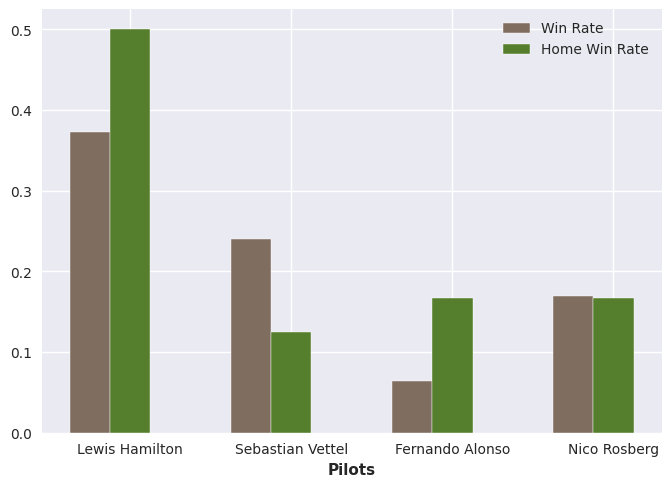

In [11]:
# Lewis Hamilton win rates
hamilton_wins = data[(data['driver'] == 'Lewis Hamilton') & (data['position'] == '1')]
hamilton_total = data[data['driver'] == 'Lewis Hamilton']
hamilton_win_rate = hamilton_wins.shape[0] / hamilton_total.shape[0]
print('Lewis Hamilton win rate: ', hamilton_win_rate)
hamilton_home_wins = data[(data['driver'] == 'Lewis Hamilton') & (data['position'] == '1') & (data['driver_home'] == 1)]
hamilton_home_total = data[(data['driver'] == 'Lewis Hamilton') & (data['driver_home'] == 1)]
hamilton_home_win_rate = hamilton_home_wins.shape[0] / hamilton_home_total.shape[0]
print('Lewis Hamilton home win rate: ', hamilton_home_win_rate)

# Sebastian Vettel win rates
vettel_wins = data[(data['driver'] == 'Sebastian Vettel') & (data['position'] == '1')]
vettel_total = data[data['driver'] == 'Sebastian Vettel']
vettel_win_rate = vettel_wins.shape[0] / vettel_total.shape[0]
print('Sebastian Vettel win rate: ', vettel_win_rate)
vettel_home_wins = data[(data['driver'] == 'Sebastian Vettel') & (data['position'] == '1') & (data['driver_home'] == 1)]
vettel_home_total = data[(data['driver'] == 'Sebastian Vettel') & (data['driver_home'] == 1)]
vettel_home_win_rate = vettel_home_wins.shape[0] / vettel_home_total.shape[0]
print('Sebastian Vettel home win rate: ', vettel_home_win_rate)

# Fernando Alonso win rates
alonso_wins = data[(data['driver'] == 'Fernando Alonso') & (data['position'] == '1')]
alonso_total = data[data['driver'] == 'Fernando Alonso']
alonso_win_rate = alonso_wins.shape[0] / alonso_total.shape[0]
print('Fernando Alonso win rate: ', alonso_win_rate)
alonso_home_wins = data[(data['driver'] == 'Fernando Alonso') & (data['position'] == '1') & (data['driver_home'] == 1)]
alonso_home_total = data[(data['driver'] == 'Fernando Alonso') & (data['driver_home'] == 1)]
alonso_home_win_rate = alonso_home_wins.shape[0] / alonso_home_total.shape[0]
print('Fernando Alonso home win rate: ', alonso_home_win_rate)

# Nico Rosberg win rates
rosberg_wins = data[(data['driver'] == 'Nico Rosberg') & (data['position'] == '1')]
rosberg_total = data[data['driver'] == 'Nico Rosberg']
rosberg_win_rate = rosberg_wins.shape[0] / rosberg_total.shape[0]
print('Nico Rosberg win rate: ', rosberg_win_rate)
rosberg_home_wins = data[(data['driver'] == 'Nico Rosberg') & (data['position'] == '1') & (data['driver_home'] == 1)]
rosberg_home_total = data[(data['driver'] == 'Nico Rosberg') & (data['driver_home'] == 1)]
rosberg_home_win_rate = rosberg_home_wins.shape[0] / rosberg_home_total.shape[0]
print('Nico Rosberg home win rate: ', rosberg_home_win_rate)

pilots = ['Lewis Hamilton', 'Sebastian Vettel', 'Fernando Alonso', 'Nico Rosberg']
win_rate = [hamilton_win_rate, vettel_win_rate, alonso_win_rate, rosberg_win_rate]
home_win_rate = [hamilton_home_win_rate, vettel_home_win_rate, alonso_home_win_rate, rosberg_home_win_rate]

# Barplot dos dados
fig, ax = plt.subplots()
barWidth = 0.25
r1 = np.arange(len(pilots))
r2 = [x + barWidth for x in r1]
plt.bar(r1, win_rate, color='#7f6d5f', width=barWidth, edgecolor='white', label='Win Rate')
plt.bar(r2, home_win_rate, color='#557f2d', width=barWidth, edgecolor='white', label='Home Win Rate')
plt.xlabel('Pilots', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(pilots))], pilots)
plt.legend()
plt.show()

A coluna statusId possui 136 diferentes codigos para representar possiveis resultados de um piloto em uma corrida (status.csv).

Ex 1: Caso o piloto saia da corrida por conta de uma asa quebrada, o statusId sera 41.

Ex 2: Caso o piloto saia da corrida por conta de um acidente, o statusId sera 73.

Para simplificar a analise, foi criado uma coluna representando se o piloto teve que sair da corrida (DNF - Did Not Finish) independente do motivo.


In [12]:
# DNF causado por culpa do piloto
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)

# DNF causado por culpa da equipe
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)

Adição da nova coluna driver_confidence que é baseado na quantidade de DNFs causados por culpa do piloto.

Caso o piloto tenha mais confiança com o carro, é menos provável que ele bata e saia da corrida. Por isso a quantidade de DNFs causados pelo piloto foi utilizado para calcular a confiança do piloto.

In [13]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = dnf_by_driver / driver_race_entered
driver_confidence = 1 - driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))
data['driver_confidence'] = data['driver'].map(driver_confidence_dict)

Semelhante ao calculo da confiança do piloto, a confiabilidade da equipe se baseia na quantidade de vezes que foi causado DNF por culpa da equipe.

In [14]:
dnf_by_constructor = data.groupby('name_constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('name_constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))
data['constructor_reliability'] = data['name_constructor'].map(constructor_relaiblity_dict)

A principal vantagem de obter um modelo para predizer o resultado de corridas é utiliza-la em corridas futuras. Por isso foi mantido dados somente de equipes que ainda (temporada de 2020) participam da F1.

O mesmo pode ser aplicado para os pilotos.

In [15]:
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
data['active_constructor'] = data['name_constructor'].apply(lambda x: 1 if x in active_constructors else 0)

active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))

Colunas finais após modificações.

In [16]:
print('Colunas restantes: ', data.columns)

Colunas restantes:  Index(['year', 'date', 'url', 'quali_position', 'position', 'statusId',
       'number_driver', 'forename', 'surname', 'dob', 'nationality_driver',
       'url_driver', 'name_constructor', 'nationality_constructor',
       'url_constructor', 'GP_name', 'country', 'driver', 'age_at_gp_in_days',
       'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf',
       'driver_confidence', 'constructor_reliability', 'active_constructor',
       'active_driver'],
      dtype='object')


##### 3.1.3. Criação do novo dataframe

Depois dessas manipulações de colunas, existem colunas que não serão mais utilizadas ou foram transformadas em outras. Por isso é necessário criar um novo dataframe somente com as colunas úteis.

In [17]:
# Utilizar somente colunas necessárias
cleaned_data = data[['GP_name','quali_position','name_constructor', 'age_at_gp_in_days',
    'driver','position','driver_confidence','constructor_reliability',
    'active_driver','active_constructor']]

# Manter pilotos e equipes que ainda existem na F1
cleaned_data = cleaned_data[cleaned_data['active_driver']==1]
cleaned_data = cleaned_data[cleaned_data['active_constructor']==1]
cleaned_data = cleaned_data.drop(['active_driver','active_constructor'], axis=1)

print('Colunas restantes: ', cleaned_data.columns)

Colunas restantes:  Index(['GP_name', 'quali_position', 'name_constructor', 'age_at_gp_in_days',
       'driver', 'position', 'driver_confidence', 'constructor_reliability'],
      dtype='object')


Dessa forma, o dataframe limpo está exibido abaixo.

As colunas utilizadas são:
- **GP_name**: Nome do GP
- **quali_position**: Posição do piloto na qualificação
- **name_constructor**: Nome da equipe
- **age_at_gp_in_days**: Idade do piloto em dias no dia da corrida
- **driver**: Nome do piloto
- **position**: Posição do piloto na corrida. O valor '\N' representa que o piloto não finalizou a corrida.
- **driver_confidence**: Confiança do piloto
- **constructor_reliability**: Confiabilidade da equipe
- **driver_home**: Se o piloto é da mesma nacionalidade do país que cede o GP
- **constructor_home**: Se a equipe é da mesma nacionalidade do país que cede o GP

Cada linha representa o resultado de uma corrida. O objetivo é prever a posição do piloto na corrida.

In [18]:
cleaned_data.head(3)

,GP_name,quali_position,name_constructor,age_at_gp_in_days,driver,position,driver_confidence,constructor_reliability
39,Albert Park Grand Prix Circuit,12,Renault,10851,Daniel Ricciardo,\N,0.942197,0.530151
40,Albert Park Grand Prix Circuit,14,Renault,8567,Kevin Magnussen,12,0.952381,0.530151
41,Albert Park Grand Prix Circuit,9,Renault,8606,Carlos Sainz,10,0.903846,0.530151


### 3.2. Manipulação de variáveis qualitativas e quantitativas

Os classificadores utilizam, normalmente, somente variáveis inteiras ou reais. Por isso é necessário passar variáveis qualitativas para variáveis quantitativas. E de modo semelhantes ajustar os valores de variáveis quantitativas de modo que seja mais significante para o modelo.

Como predizer a posição exata de um piloto é muito dificil, a coluna 'position' será transformada em uma coluna com 3 valores. 0 caso o piloto termine no podio, 1 caso o piloto termine entre a quarta e a decima posição e 2 caso o piloto termine abaixo da decima posição.

In [19]:
# Função para converter o valor da posição do piloto para um dos tres valores [0, 1, 2]
def position_index(position):
    # Posição para obter um pódio
    if position <= 3:
        return 0
    # Posição para obter pontos mas fora do pódio
    elif position <= 10:
        return 1
    # Posição de finalização para não obter pontos
    else:
        return 2

Padronização dos dados utilizando *StandardScaler* para normalizar valores inteiros e *LabelEncoder* para codificar variáveis qualitativas.

In [20]:
sc = StandardScaler()
le = LabelEncoder()

formatted_data = cleaned_data.copy()

DNF_POSITION = 20
formatted_data['position'] = formatted_data['position'].apply(lambda x: int(x) if x!='\\N' else DNF_POSITION)

formatted_data['GP_name'] = le.fit_transform(formatted_data['GP_name'])
formatted_data['name_constructor'] = le.fit_transform(formatted_data['name_constructor'])
formatted_data['driver'] = le.fit_transform(formatted_data['driver'])

formatted_data['age_at_gp_in_days'] = sc.fit_transform(formatted_data['age_at_gp_in_days'].values.reshape(-1,1))

### 3.3. Divisão dos dados para treino e teste

Os dados para treinos envolverão o descobrimento de hiper-parâmetros para o modelo. Os dados de teste serão utilizados para verificar a acurácia do modelo no fim.

**Relembrando**: A coluna utilizada como label dos dados é a posição do piloto no final da corrida.

In [21]:
X = formatted_data.drop(['position'],1)
y = formatted_data['position'].apply(position_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 4. Modelos

Os modelos utilizados foram:
- **Decision Tree**: Árvore de decisão
- **Multi-layer Perceptron**: Rede neural
- **Gaussian Naive Bayes**: Classificador Naive Bayes
- **KNNeighbors**: Classificador KNN

### 4.1. Visualização inicial

Antes de começar a testar os hiper parâmetros, uma visão inicial das precisões dos modelos pode ser obtido utilizando os hiper-parâmetros padrões.

Abaixo é exibido um Boxplot com a precisão de cada modelo após utilizado 10-fold stratified cross validation.

DecisionTreeClassifier : 0.5159409218232748
MLPClassifier : 0.6232874968169086
GaussianNB : 0.6070155334861216
KNeighborsClassifier : 0.5738689415160002


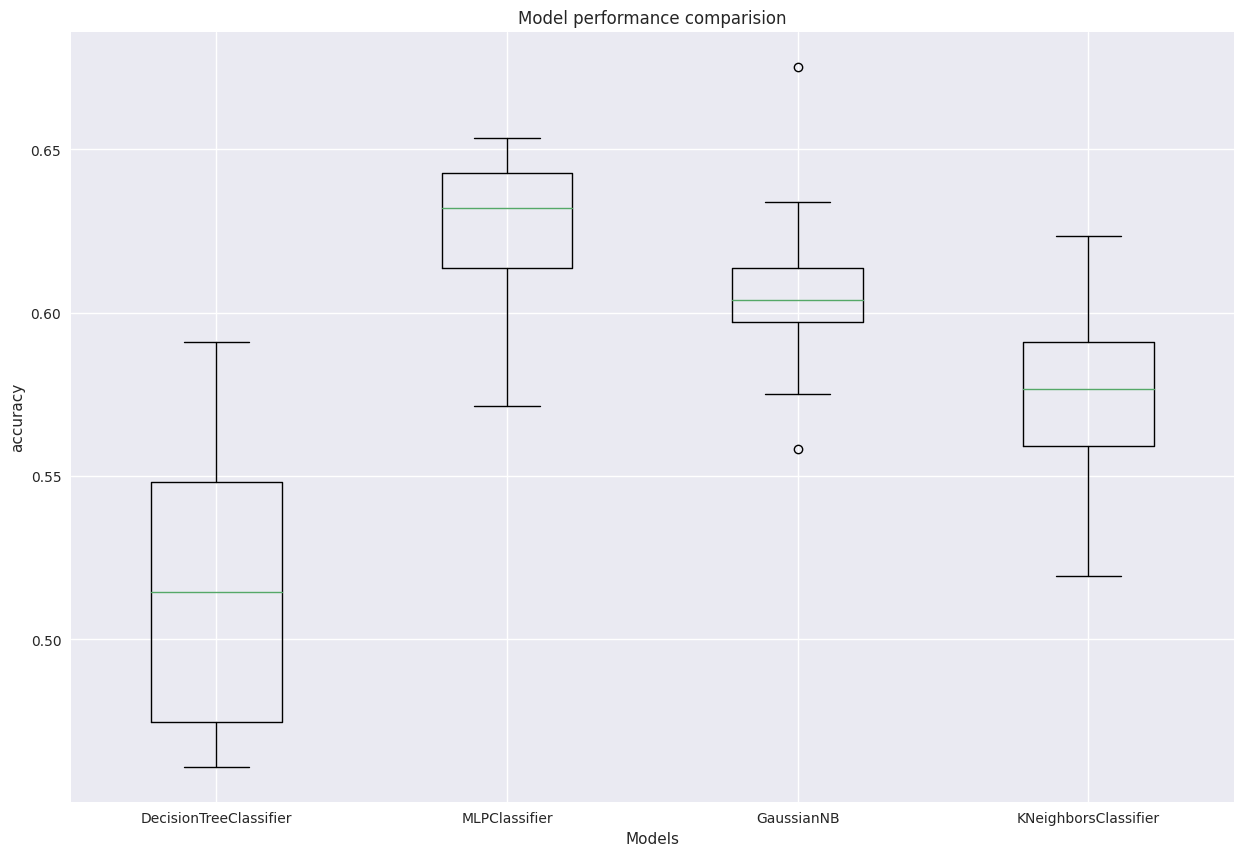

In [22]:
models = [DecisionTreeClassifier(),MLPClassifier(),GaussianNB(),KNeighborsClassifier()]
names = ['DecisionTreeClassifier','MLPClassifier','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)
    result = cross_val_score(model,X_train,y_train,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### 4.2. Otimização dos hiper-parâmetros

Cada um dos modelos utilizados possuem hiper-parâmetros que podem ser ajustados para melhorar a precisão do modelo. Por isso, foi utilizado o RandomizedSearchCV para encontrar os melhores hiper-parâmetros para cada modelo baseado em uma lista de parâmetros pré-definidos.

#### 4.2.1. Decision Tree

In [23]:
# Definição do intervalo de parâmetros utilizados
dt_param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'max_features': ['sqrt','log2']
}

dt_rand_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=dt_param_grid, n_iter=100, cv=10, random_state=SEED, n_jobs=2)
dt_rand_search.fit(X_train,y_train)
print('Parametros encontrados: ', dt_rand_search.best_params_)

Parametros encontrados:  {'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}


#### 4.2.2. Multilayer Perceptron Classifier

In [24]:
# mlp_param_grid = {
#     'hidden_layer_sizes': [(100,),(200,),(300,)],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'solver': ['lbfgs', 'sgd', 'adam'],
#     'alpha': [0.0001,0.001],
#     'learning_rate': ['constant', 'invscaling', 'adaptive']
# }

# mlp_rand_search = RandomizedSearchCV(MLPClassifier(), param_distributions=mlp_param_grid, n_iter=10, cv=10, random_state=SEED, n_jobs=2)
# mlp_rand_search.fit(X_train,y_train)
# print(mlp_rand_search.best_params_)

# TODO: Remover mock
class asdf:
    def __init__(self):
        self.best_params_ = {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.0001, 'activation': 'logistic'}

mlp_rand_search = asdf()

#### 4.2.3. Naive Bayes Classifier

In [25]:
nb_param_grid = {
    'var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
}

nb_rand_search = RandomizedSearchCV(GaussianNB(), param_distributions=nb_param_grid, n_iter=100, cv=10, random_state=SEED, n_jobs=2)
nb_rand_search.fit(X_train,y_train)
print(nb_rand_search.best_params_)

{'var_smoothing': 1e-05}


#### 4.2.4. K-Nearest Neighbors Classifier

In [26]:
knn_param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10,20,30,40,50,60,70,80,90,100]
}

knn_rand_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=knn_param_grid, n_iter=100, cv=10, random_state=SEED, n_jobs=2)
knn_rand_search.fit(X_train,y_train)
print(knn_rand_search.best_params_)

{'weights': 'uniform', 'n_neighbors': 20, 'leaf_size': 20, 'algorithm': 'ball_tree'}


### 4.3. Testes com parâmetros ajustados

Após a otimização dos hiper-parâmetros, o teste inicial foi repetido mas com os modelos ajustados pelos parâmetros testados. Stratified 10-Fold Cross Validation foi utilizado para obter um boxplot dos resultados.

DecisionTreeClassifier : 0.601854681266446
MLPClassifier : 0.6154740684152449
GaussianNB : 0.6096214243273066
KNeighborsClassifier : 0.5999023851965027


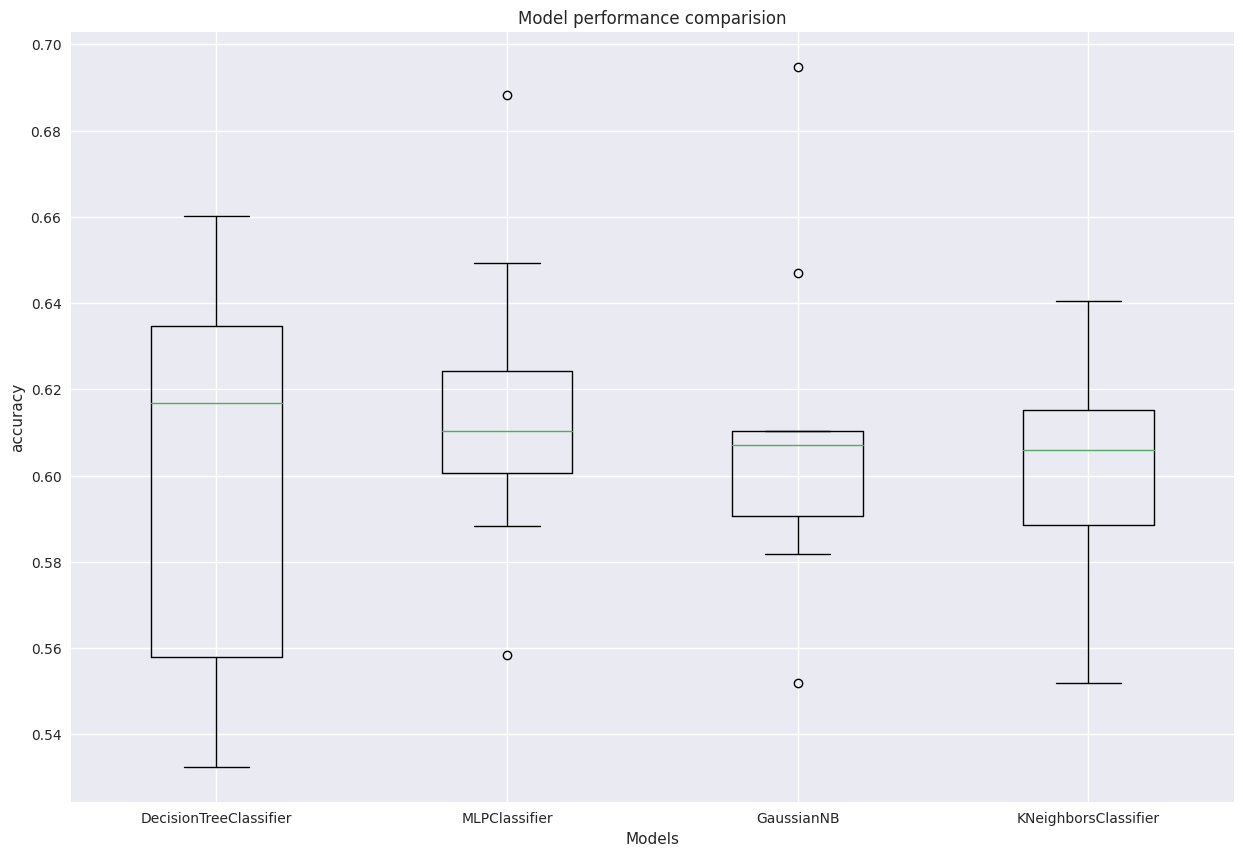

In [27]:
models = [
    DecisionTreeClassifier(**dt_rand_search.best_params_),
    MLPClassifier(**mlp_rand_search.best_params_),
    GaussianNB(**nb_rand_search.best_params_),
    KNeighborsClassifier(**knn_rand_search.best_params_)]
names = ['DecisionTreeClassifier','MLPClassifier','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)
    result = cross_val_score(model,X_train,y_train,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### 4.4. Testes finais

Testes finais envolvendo o conjunto de dados reservado para testes. Utilizado os parâmetros encontrados no RandomizedSearchCV.

Os resultados finais foram exibidos utilizando um heatmap para mostrar qual a eficiencia em cada tipo de classe.

#### 4.4.1. Decision Tree

Decision Tree ccuracy: 0.6103896103896104


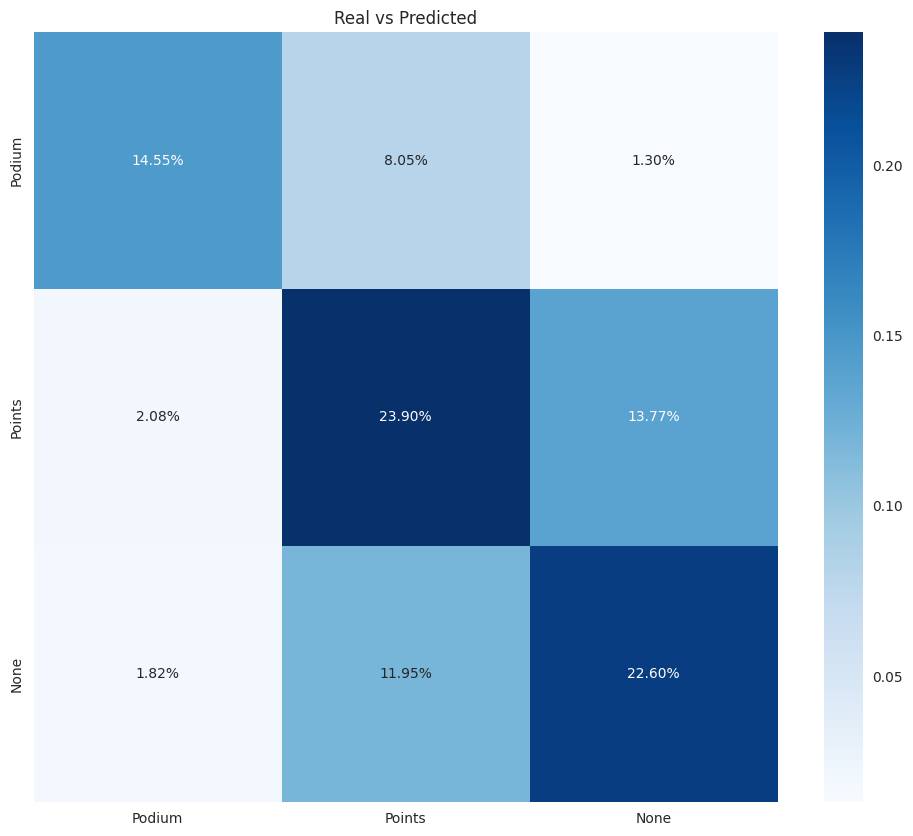

In [28]:
dt_clf = DecisionTreeClassifier(**dt_rand_search.best_params_)
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
print(f'Decision Tree ccuracy: {accuracy_score(y_test,dt_pred)}')
cnf_mat_dt = confusion_matrix(y_test,dt_pred)

# Heatmap confusion matrix cnf_mat_dt with ratio of each class
plt.figure(figsize=(12,10))
sns.heatmap(cnf_mat_dt/np.sum(cnf_mat_dt, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Real vs Predicted')
plt.show()

#### 4.4.2. Multilayer Perceptron Classifier

MLP Accuracy: 0.6025974025974026


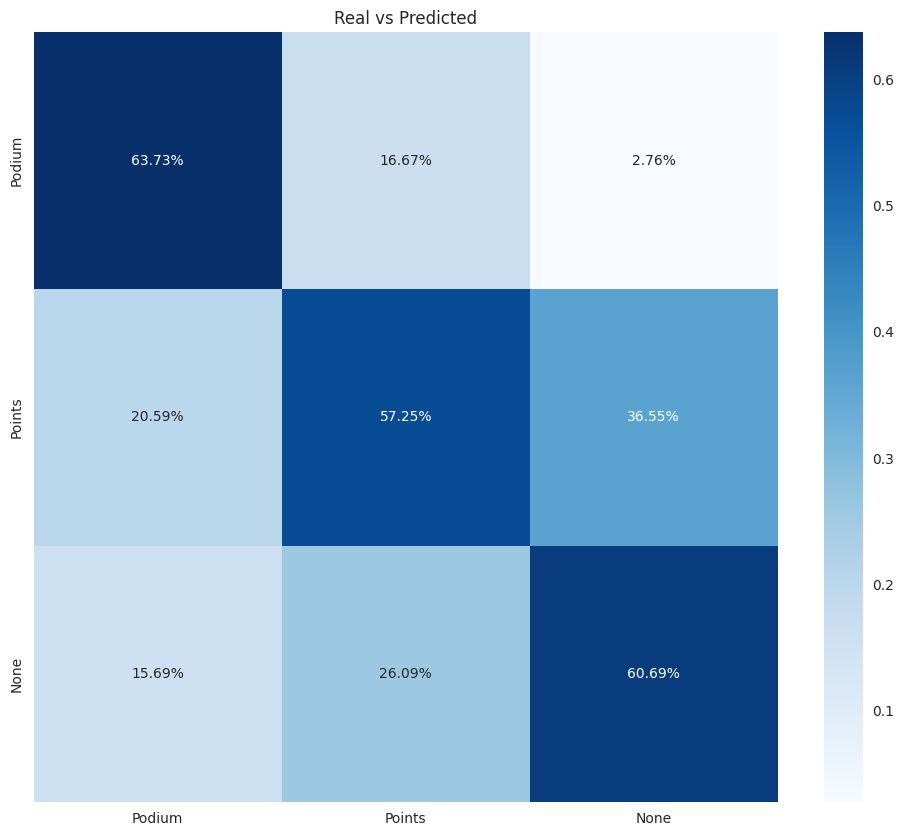

In [31]:
mlp_clf = MLPClassifier(**mlp_rand_search.best_params_)
mlp_clf.fit(X_train,y_train)
mlp_pred = mlp_clf.predict(X_test)
print(f'MLP Accuracy: {accuracy_score(y_test,mlp_pred)}')

cnf_mat_mlp = confusion_matrix(y_test,mlp_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cnf_mat_mlp/np.sum(cnf_mat_mlp, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Real vs Predicted')
plt.show()

#### 4.4.3. Gaussian Naive Bayes

Gaussian Naive Bayes: 0.6025974025974026


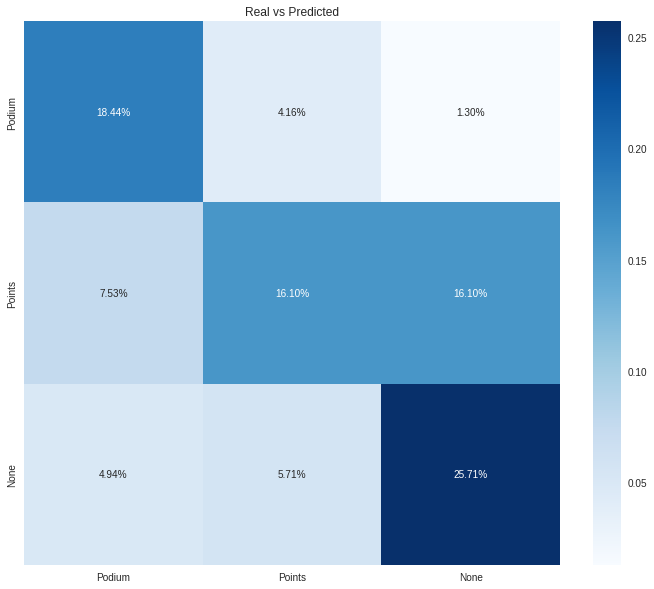

In [78]:
nb_clf = GaussianNB(**nb_rand_search.best_params_)
nb_clf.fit(X_train,y_train)
nb_pred = nb_clf.predict(X_test)
print(f'Gaussian Naive Bayes: {accuracy_score(y_test,nb_pred)}')

cnf_mat_nb = confusion_matrix(y_test,nb_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cnf_mat_nb/np.sum(cnf_mat_nb, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Real vs Predicted')
plt.show()

#### 4.4.4. K-Nearest Neighbors

Accuracy: 0.6181818181818182


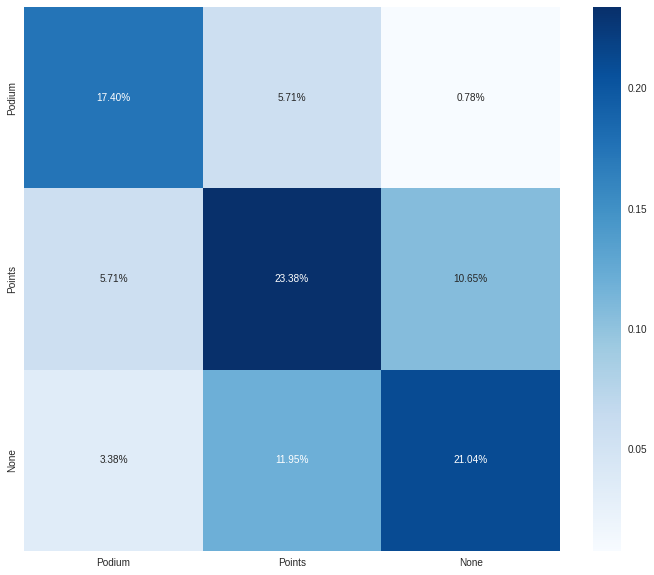

In [75]:
knn_clf = KNeighborsClassifier(**knn_rand_search.best_params_)
knn_clf.fit(X_train,y_train)
knn_pred = knn_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,knn_pred)}')

cnf_mat_knn = confusion_matrix(y_test,knn_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cnf_mat_knn/np.sum(cnf_mat_knn, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Real vs Predicted')
plt.show()

## 5. Conclusão

### 5.1. Resultados finais

#### 5.1.1. Tabela de precisões finais

In [77]:
model_accuracies = pd.DataFrame({
    'Model': ['DecisionTreeClassifier','MLPClassifier','GaussianNB','KNeighborsClassifier'],
    'Accuracy': [accuracy_score(y_test,dt_pred),accuracy_score(y_test,mlp_pred),accuracy_score(y_test,nb_pred),accuracy_score(y_test,knn_pred)]
})
model_accuracies.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,KNeighborsClassifier,0.618182
0,DecisionTreeClassifier,0.602597
2,GaussianNB,0.602597
1,MLPClassifier,0.600000


#### 5.1.2. Heatmaps finais


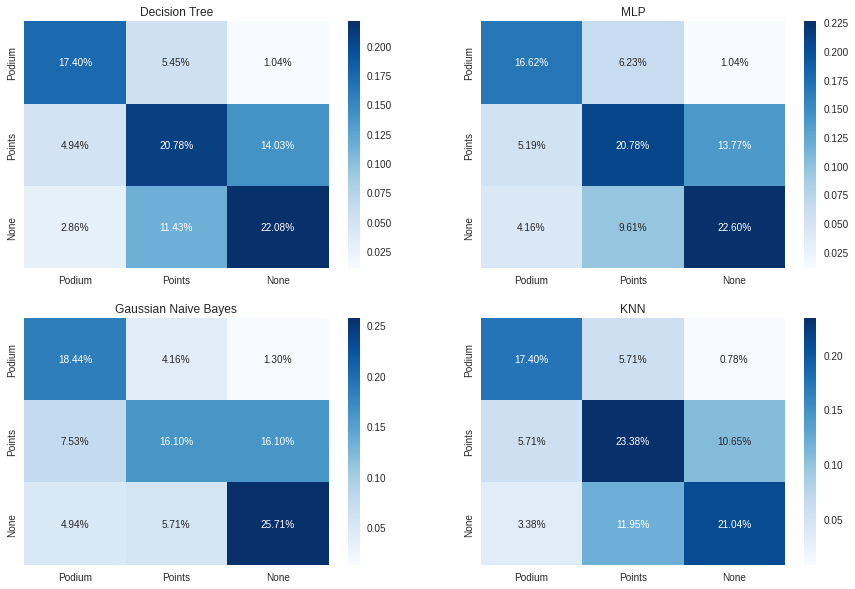

In [76]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.heatmap(cnf_mat_dt/np.sum(cnf_mat_dt), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Decision Tree')
plt.subplot(2,2,2)
sns.heatmap(cnf_mat_mlp/np.sum(cnf_mat_mlp), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('MLP')
plt.subplot(2,2,3)
sns.heatmap(cnf_mat_nb/np.sum(cnf_mat_nb), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('Gaussian Naive Bayes')
plt.subplot(2,2,4)
sns.heatmap(cnf_mat_knn/np.sum(cnf_mat_knn), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Podium','Points','None'], yticklabels=['Podium','Points','None'])
plt.title('KNN')
plt.show()

#### 5.1.1. Diferença absoluta entre os melhores classificadores

### 5.2. Problemas encontrados